In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from extract_transform import get_match

In [2]:
# TODO - add docstrings, maybe move functions to modules
def llf(leaf_id): # leaf label func for dendrogram adapted from scipy docs
    return wikidata.loc[leaf_id, 'name']

# map names based on whether their wikidata desc contains 'chain' and 'restaurant'
def get_color(ylabel): 
    try:
        color = color_dict[ylabel.get_text()]
    except:
        color = 'b'
    return color

In [3]:
raw_wikidata = pd.read_json('data/wikidata.json')
preprocessed_wikidata = pd.read_json('data/preprocessed-wikidata.json')
wikidata = raw_wikidata.merge(preprocessed_wikidata, on='qid')

In [4]:
wikidata['name'] = wikidata['names'].apply(lambda names: names[0])
descriptions = wikidata['preprocessed_description']

In [5]:
contains_chain = wikidata['preprocessed_description'].apply(
    lambda description: get_match('chain', description)
).notna()

contains_restaurant = wikidata['preprocessed_description'].apply(
    lambda description: get_match('restaurant', description)
).notna()
contains_chain_and_restaurant = (contains_chain & contains_restaurant)
# -> regex approach, pretty sure descriptions that contain the words 'chain' and 'restaurant'
# represent chain restaurants, more false negatives (not all descriptions for chain 
# restaurants contain both the words 'chain' and 'restaurant')

In [6]:
# color names associated with wikidata descriptions that contain 'chain' and 'restaurant' red
# -> compare regex predictions with cosine similarity clusters
color_dict = {}
for name in wikidata.loc[contains_chain_and_restaurant, 'name'].values:
    color_dict[name] = 'r'

In [7]:
vectorizer = CountVectorizer(lowercase=False)
document_term_matrix = vectorizer.fit_transform(descriptions)
cosine_similarities = cosine_similarity(document_term_matrix)

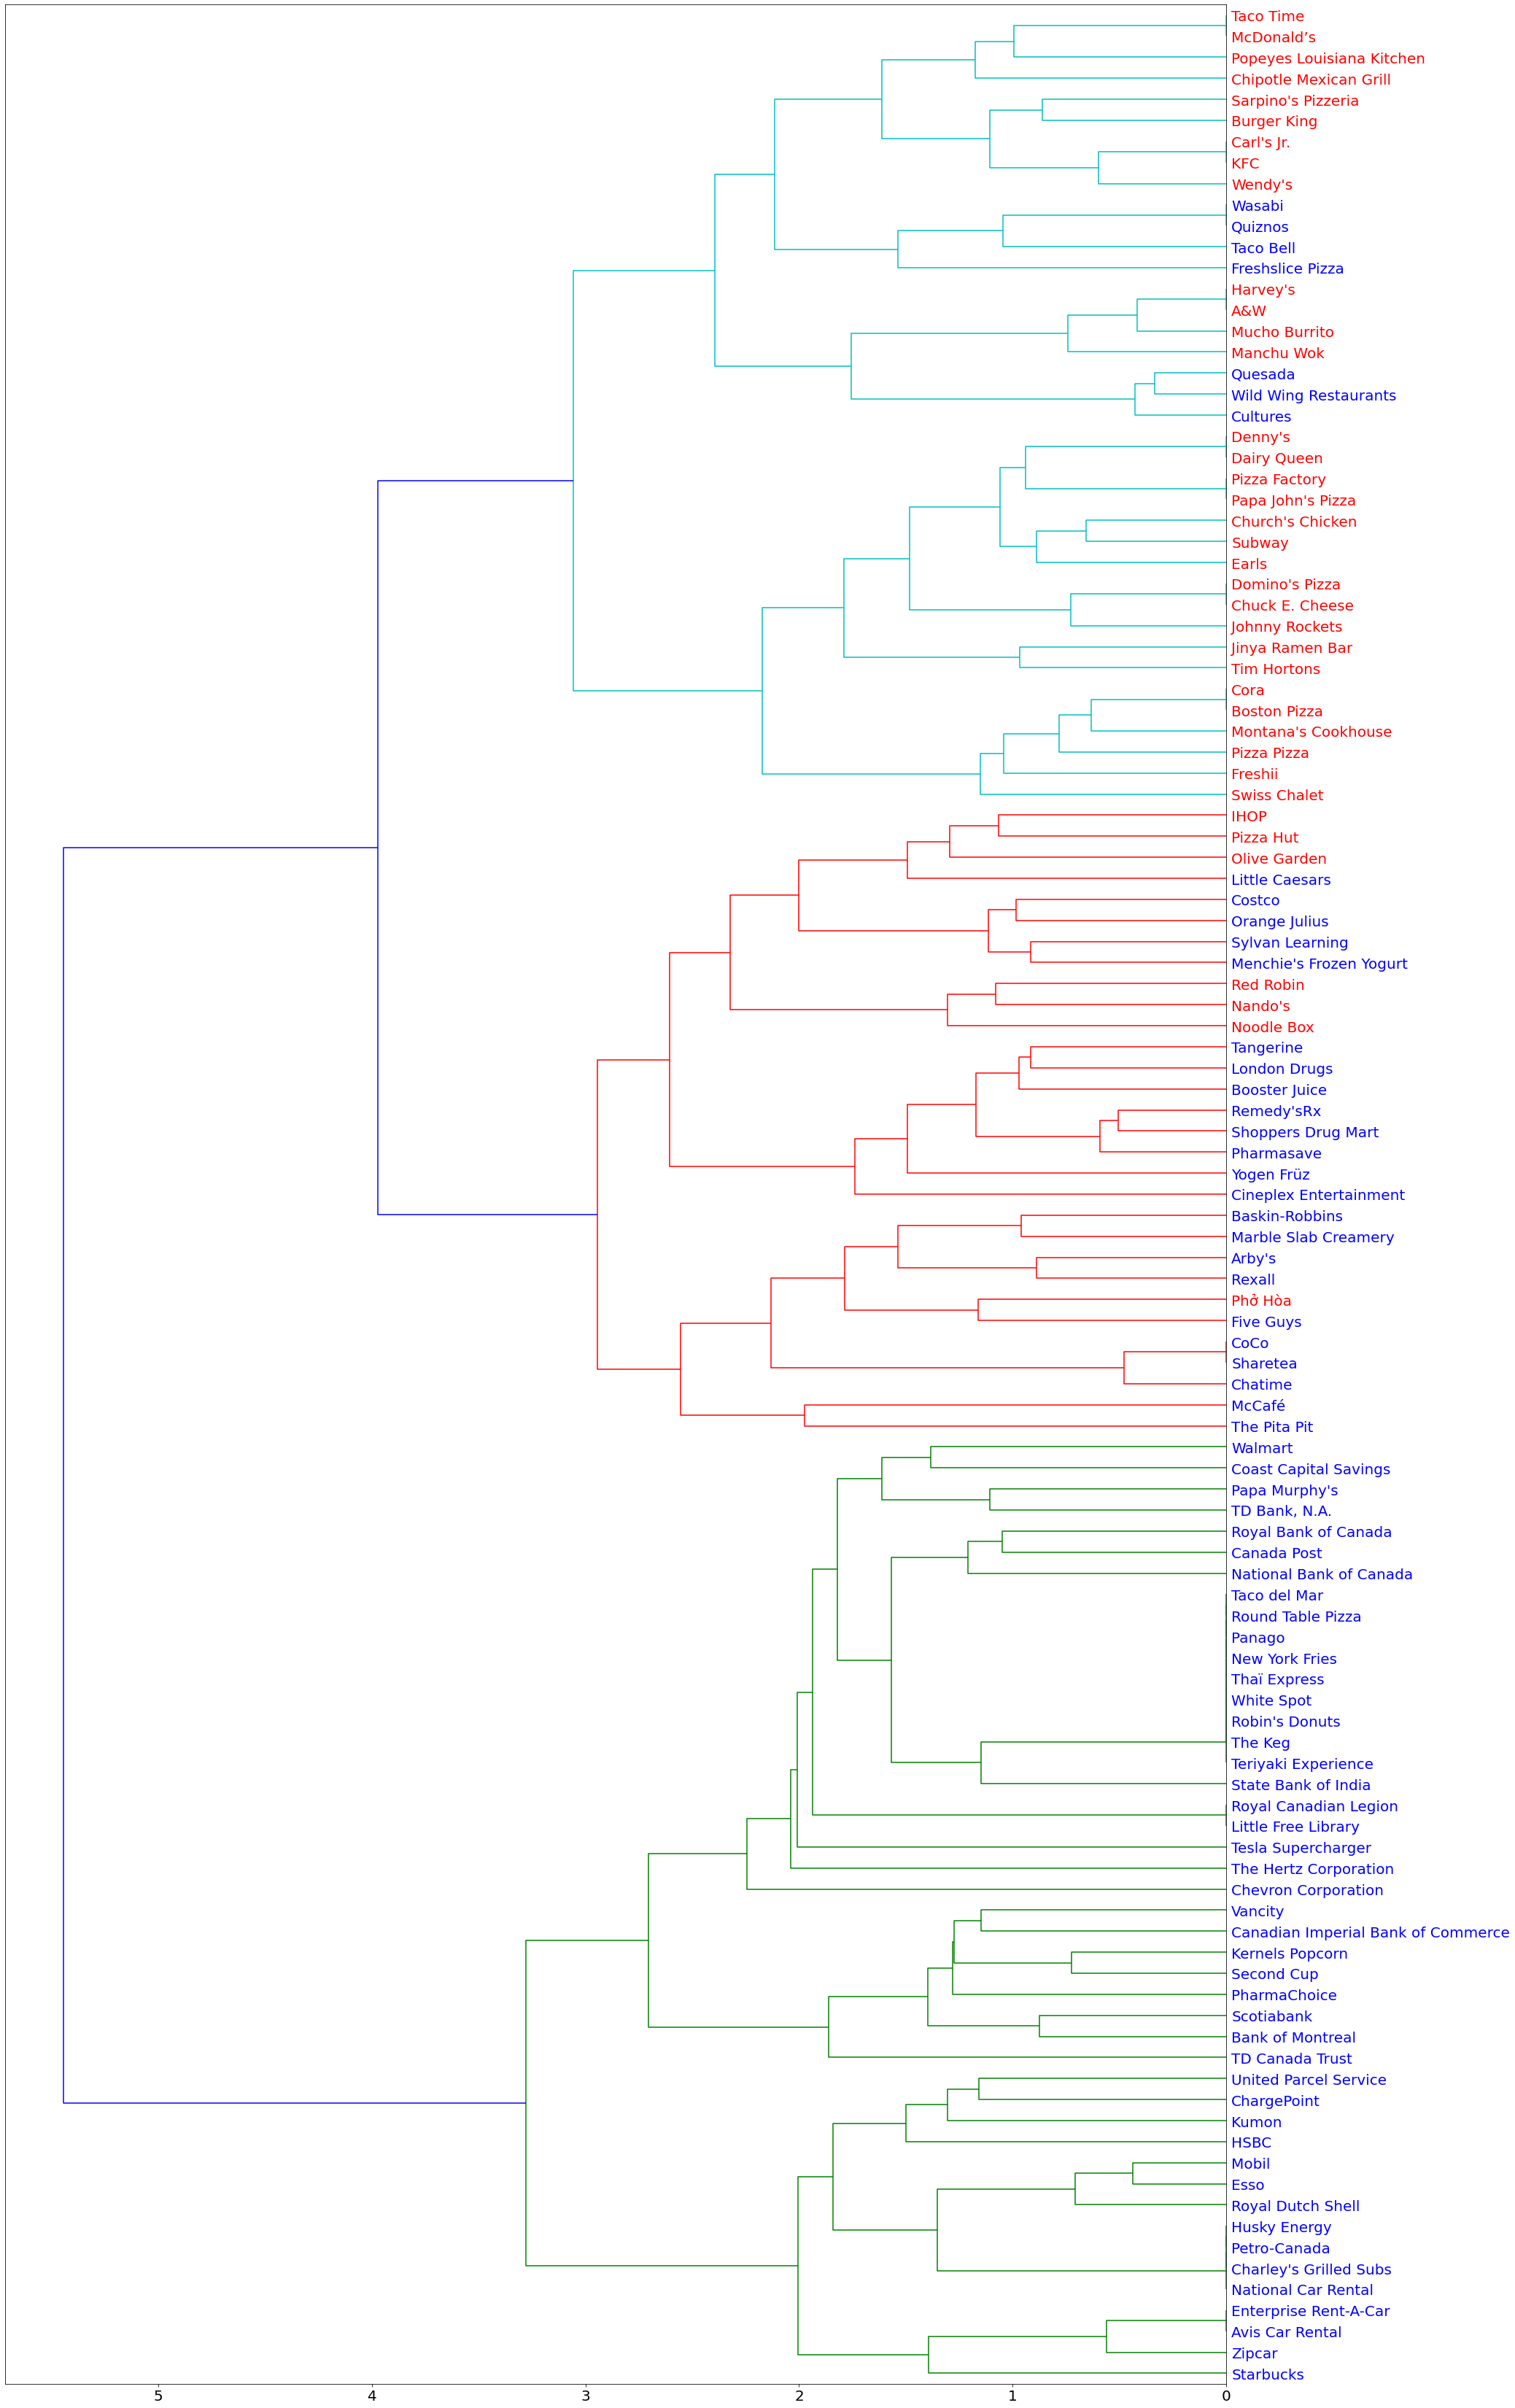

In [8]:
# scipy dendrogram docs
Z = linkage(cosine_similarities, method='complete')

fig = plt.figure(figsize=(30, 60))
dn = dendrogram(Z, leaf_label_func=llf, orientation='left', leaf_font_size=20)

# different label colors adapted from Warren Weckesser's answer at 
# https://stackoverflow.com/questions/14802048/
ax = plt.gca()
ylabels = ax.get_ymajorticklabels()
for ylabel in ylabels:
    ylabel.set_color(get_color(ylabel))
    
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [ ]:
# cluster actually groups some chain restaurants with descriptions that do not contain the words
# 'chain' or 'restaurant'